#### Import libraries

In [1]:
# standard setup
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
import time

# useful helper function
from helpers import imshow

#### Helper Script for capturing images

In [2]:
# Camera settings
camera = cv2.VideoCapture(0)
# reduce frame size to speed it up
w = 640*1.5
h = w*3/4
camera.set(cv2.CAP_PROP_FRAME_WIDTH, w) 
camera.set(cv2.CAP_PROP_FRAME_HEIGHT, h) 
camera.set(cv2.CAP_PROP_EXPOSURE,-4) 
i = 0
while True:
    # Get frame at flip it
    ret, frame = camera.read()
    frame = cv2.flip(frame, 1)
    
    # Press space bar for capturing an image
    if cv2.waitKey(5) == 32:
        imshow(frame)
        cv2.imwrite("im-" + str(i) + ".jpg", frame)
        i += 1
    elif cv2.waitKey(5) == 27:
        break  
   
    cv2.imshow("Frame", frame)
    
cv2.destroyAllWindows()
camera.release()
cv2.waitKey(1) # extra waitKey sometimes needed to close camera window

27

#### Extracting SIFT features from the book

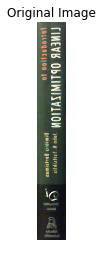

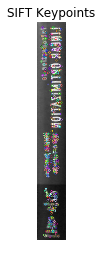

In [367]:
# Import original image
img = cv2.imread('book3.jpg')
imshow(img, "Original Image")

# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# imshow(gray, "Grayscale Image")

# compute SIFT keypoints
sift = cv2.xfeatures2d.SIFT_create()
kp0 = sift.detect(gray,None)
image_with_keypoints = cv2.drawKeypoints(gray,kp0,gray)
imshow(image_with_keypoints, "SIFT Keypoints")

#### Real time book spine tracking with SIFT features: Slow Performance

In [4]:
# SIFT keypoint detector
sift = cv2.xfeatures2d.SIFT_create()

# Import the query image and compute SIFT keypoints and descriptors
query_img = cv2.imread('book4.jpg')
query_kp, query_des = sift.detectAndCompute(query_img,None)

# FLANN parameters
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv2.FlannBasedMatcher(index_params,search_params)

# Camera settings
camera = cv2.VideoCapture(0)
# reduce frame size to speed it up
w = 640*1.5
camera.set(cv2.CAP_PROP_FRAME_WIDTH, w) 
camera.set(cv2.CAP_PROP_FRAME_HEIGHT, w * 3/4) 
camera.set(cv2.CAP_PROP_EXPOSURE,-4) 
while True:
    # Get frame at flip it
    ret, frame = camera.read()
    frame = cv2.flip(frame, 1)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    
    # keypoints and descriptors for video frame (train image)
    train_kp, train_des = sift.detectAndCompute(gray,None)
    
    # Get matches with the knnMatch flann matching method
    matches = flann.knnMatch(query_des,train_des,k=2)

    # ratio test as per Lowe's paper to filter the good matches out
    good_matches = []
    
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good_matches.append(m)

    # Initialize the list of points corresponding to matched keypoints 
    # in the train image
    matched_train_kp = []

    # For each match...
    for mat in good_matches:
        # Get the matching keypoints for training
        matched_train_idx = mat.trainIdx
        
        # get coordinates and append them to the list
        (x,y) = train_kp[matched_train_idx].pt
        matched_train_kp.append((x, y))
        
    # Add small circles corresponding to the matched keypoints to the video frame
    for (x,y) in matched_train_kp:
        cv2.circle(frame,(int(x),int(y)), 2, (255,0,255), 3)
    
    if cv2.waitKey(5) == 32:
        imshow(frame)        
    elif cv2.waitKey(5) == 27:
        break  
   
    cv2.imshow("Frame", frame)
    
cv2.destroyAllWindows()
camera.release()
cv2.waitKey(1) # extra waitKey sometimes needed to close camera window

-1

#### Extracting ORB (Oriented FAST and Rotated BRIEF) Features

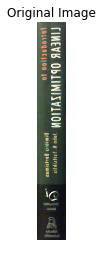

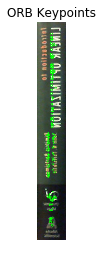

In [370]:
# Import original image
img = cv2.imread('book3.jpg')
imshow(img, "Original Image")

# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


# Initiate ORB detector
orb = cv2.ORB_create()

# find the keypoints with ORB
kp = orb.detect(gray, None)

# draw only keypoints location,not size and orientation
image_with_keypoints = cv2.drawKeypoints(img, kp, img, color=(0,255,0), flags=0)

imshow(image_with_keypoints, "ORB Keypoints")

#### Matching ORB Features in a Picture, BruteForce Matcher - Bad Performance

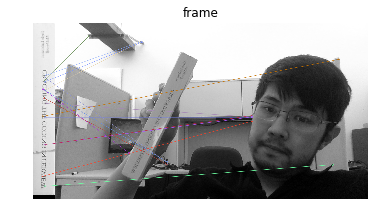

In [7]:
MIN_MATCHES = 15
cap = cv2.imread('scene2.jpg', 0)    
model = cv2.imread('book4.jpg', 0)

# ORB keypoint detector
orb = cv2.ORB_create()              
# create brute force  matcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)  

# Compute model keypoints and its descriptors
kp_model, des_model = orb.detectAndCompute(model, None)  
# Compute scene keypoints and its descriptors
kp_frame, des_frame = orb.detectAndCompute(cap, None)
# Match frame descriptors with model descriptors
matches = bf.match(des_model, des_frame)
# Sort them in the order of their distance
matches = sorted(matches, key=lambda x: x.distance)


if len(matches) > MIN_MATCHES:
    # draw first 15 matches.
    cap = cv2.drawMatches(model, kp_model, cap, kp_frame,
                          matches[:MIN_MATCHES], 0, flags=2)
    # show result
    imshow(cap, 'frame')
else:
    print "Not enough matches have been found - %d/%d" % (len(matches),
                                                          MIN_MATCHES)

#### Matching ORB Features in a Picture, Flann Matcher

14 matches found


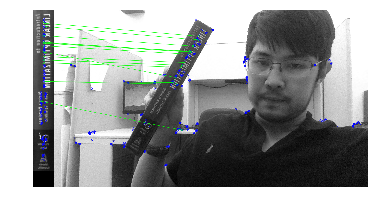

In [371]:
cap = cv2.imread('scene1.jpg', 0)    
model = cv2.imread('book3.jpg', 0)

# ORB keypoint detector
orb = cv2.ORB_create()              

# FLANN parameters
FLANN_INDEX_LSH = 6
# index_params for ORB features
index_params= dict(algorithm = FLANN_INDEX_LSH,
                   table_number = 6, # 12
                   key_size = 12,     # 20
                   multi_probe_level = 1) #2
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv2.FlannBasedMatcher(index_params,search_params)

# Compute keypoints and descriptors
kp_model, des_model = orb.detectAndCompute(model, None)  
kp_frame, des_frame = orb.detectAndCompute(cap, None)

# Match frame descriptors with model descriptors
matches = flann.knnMatch(des_model,des_frame,k=2)

# print matches

# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in xrange(len(matches))]

num = 0
# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        matchesMask[i]=[1,0]
        num += 1

print "{} matches found".format(num)
        
draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = 0)


img3 = cv2.drawMatchesKnn(model,kp_model,cap,kp_frame,matches,None,**draw_params)

imshow(img3)

#### Real time book spine tracking with ORB features

In [25]:
# Import the query image and compute ORB keypoints and descriptors
query_img = img = cv2.imread('book3.jpg', 0)
query_kp, query_des = orb.detectAndCompute(query_img, None)  

# ORB keypoint detector
orb = cv2.ORB_create()  

# FLANN parameters
FLANN_INDEX_LSH = 6
# index_params for ORB features
index_params= dict(algorithm = FLANN_INDEX_LSH,
                   table_number = 6, # 12
                   key_size = 12,     # 20
                   multi_probe_level = 1) #2
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv2.FlannBasedMatcher(index_params,search_params)


# Camera settings
camera = cv2.VideoCapture(0)
# reduce frame size to speed it up
w = 640 * 1.5
camera.set(cv2.CAP_PROP_FRAME_WIDTH, w) 
camera.set(cv2.CAP_PROP_FRAME_HEIGHT, w * 3/4) 
camera.set(cv2.CAP_PROP_EXPOSURE,-4) 

while True:
    # Get frame at flip it
    ret, frame = camera.read()
    frame = cv2.flip(frame, 1)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # keypoints and descriptors for video frame (train image)
    train_kp, train_des = orb.detectAndCompute(gray,None)
    
    # Get matches with the knnMatch flann matching method
    matches = flann.knnMatch(query_des,train_des,k=2)

    # ratio test as per Lowe's paper to filter the good matches out
    good_matches = []
    
    # Each member of the matches list must be checked whether two neighbours really exist.
    for m_n in matches:
        if len(m_n) != 2:
            continue
        (m,n) = m_n
        if m.distance < 0.75*n.distance:
            good_matches.append(m)

    # Initialize the list of points corresponding to matched keypoints in the train image
    matched_train_kp = []

    # For each match...
    for mat in good_matches:
        # Get the matching keypoints for training
        matched_train_idx = mat.trainIdx
        
        # get coordinates and append them to the list
        (x,y) = train_kp[matched_train_idx].pt
        matched_train_kp.append((x, y))
    
#     print len(matched_train_kp)
    # Add small circles corresponding to the matched keypoints to the video frame
    for (x,y) in matched_train_kp:
        cv2.circle(frame,(int(x),int(y)), 2, (255,0,255), 3)
    
    if cv2.waitKey(5) == 32:
        imshow(frame)        
    elif cv2.waitKey(5) == 27:
        break  
   
    cv2.imshow("Frame", frame)
    
cv2.destroyAllWindows()
camera.release()
cv2.waitKey(1) # extra waitKey sometimes needed to close camera window

-1

#### Find Homography (RANSAC) Based on ORB Features

13 matches found


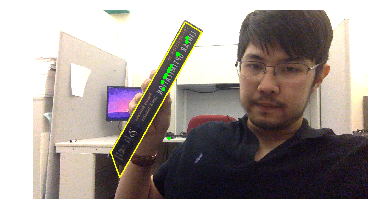

In [280]:
scene = cv2.imread('scene1.jpg', 0) 
scene_color = cv2.imread('scene1.jpg') 
query = cv2.imread('book3.jpg', 0)

# ORB keypoint detector
orb = cv2.ORB_create()              

# FLANN parameters
FLANN_INDEX_LSH = 6
# index_params for ORB features
index_params= dict(algorithm = FLANN_INDEX_LSH,
                   table_number = 6, # 12
                   key_size = 12,     # 20
                   multi_probe_level = 1) #2
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv2.FlannBasedMatcher(index_params,search_params)

# Compute keypoints and descriptors
kp_query, des_query = orb.detectAndCompute(query, None)  
kp_scene, des_scene = orb.detectAndCompute(scene, None)

# Match scene descriptors with query descriptors
matches = flann.knnMatch(des_query,des_scene,k=2)


num = 0
# ratio test as per Lowe's paper
good_matches = []

# Each member of the matches list must be checked whether two neighbours really exist.
for m_n in matches:
    if len(m_n) != 2:
        continue
    (m,n) = m_n
    if m.distance < 0.7*n.distance:
        good_matches.append(m)
        num += 1

print "{} matches found".format(num)
        
# Initialize the list of points corresponding to matched keypoints in the train image
matched_train_kp = []

# For each match...
for mat in good_matches:
    # Get the matching keypoints for training
    matched_train_idx = mat.trainIdx

    # get coordinates and append them to the list
    (x,y) = kp_scene[matched_train_idx].pt
    matched_train_kp.append((x, y))

# Add small circles corresponding to the matched keypoints to the video scene
for (x,y) in matched_train_kp:
    cv2.circle(scene_color,(int(x),int(y)), 2, (0,255,0), 10)

# Source points nad destnation points
src_pts = np.float32([kp_query[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
dst_pts = np.float32([kp_scene[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

# compute Homography
M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

# Draw a rectangle that marks the found model in the frame
h, w = query.shape
pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
# project corners into frame
dst = cv2.perspectiveTransform(pts, M)

# Draw lines
cv2.polylines(scene_color, [np.int32(dst)], True, (0, 255, 255), 3, cv2.LINE_AA) 

imshow(scene_color)

#### Find Homography (RANSAC) Based on SIFT Features

88 matches found


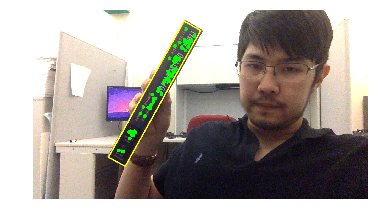

In [307]:
scene_path = 'scene1.jpg'
query_path = 'book1.jpg'

scene = cv2.imread(scene_path, 0) 
scene_color = cv2.imread(scene_path) 
query = cv2.imread(query_path, 0)

# import SIFT keypoint detector
sift = cv2.xfeatures2d.SIFT_create()

# FLANN parameters
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv2.FlannBasedMatcher(index_params,search_params)

# Compute keypoints and descriptors
kp_query, des_query = sift.detectAndCompute(query, None)  
kp_scene, des_scene = sift.detectAndCompute(scene, None)

# Match scene descriptors with query descriptors
matches = flann.knnMatch(des_query,des_scene,k=2)

# ratio test as per Lowe's paper
good_matches = []

# Each member of the matches list must be checked whether two neighbours really exist.
for m_n in matches:
    if len(m_n) != 2:
        continue
    (m,n) = m_n
    if m.distance < 0.7*n.distance:
        good_matches.append(m)

print "{} matches found".format(len(good_matches))

# If enough matches found
if len(good_matches) > 15:

    # Source points nad destnation points
    src_pts = np.float32([kp_query[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp_scene[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    
    for pt in dst_pts:
        (x,y) = pt[0]        
        cv2.circle(scene_color,(int(x),int(y)), 2, (0,255,0), 10)
        
    
    # compute Homography
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    # Draw a rectangle that marks the found model in the frame
    h, w = query.shape
    pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
    # project corners into frame
    dst = cv2.perspectiveTransform(pts, M)

    # Draw lines
    cv2.polylines(scene_color, [np.int32(dst)], True, (0, 255, 255), 3, cv2.LINE_AA) 

imshow(scene_color)

#### Real-time spine tracking using SIFT features

In [6]:
query_path = 'book3.jpg'

# SIFT keypoint detector
sift = cv2.xfeatures2d.SIFT_create()

# Import the query image and compute SIFT keypoints and descriptors
query = cv2.imread(query_path, 0)
kp_query, des_query = sift.detectAndCompute(query, None)  

# FLANN parameters
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv2.FlannBasedMatcher(index_params,search_params)

# Camera settings
camera = cv2.VideoCapture(0)
# reduce frame size to speed it up
w = 640*1.5
camera.set(cv2.CAP_PROP_FRAME_WIDTH, w) 
camera.set(cv2.CAP_PROP_FRAME_HEIGHT, w * 3/4) 
camera.set(cv2.CAP_PROP_EXPOSURE,-4) 

while True:
    # Get frame at flip it
    ret, frame = camera.read()
    frame = cv2.flip(frame, 1)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # keypoints and descriptors for video frame 
    
    kp_scene, des_scene =  sift.detectAndCompute(gray,None)
       
    # Match scene descriptors with query descriptors
    matches = flann.knnMatch(des_query,des_scene,k=2)

    # ratio test as per Lowe's paper
    good_matches = []
    # Each member of the matches list must be checked whether two neighbours really exist.
    for m_n in matches:
        if len(m_n) != 2:
            continue
        (m,n) = m_n
        if m.distance < 0.7*n.distance:
            good_matches.append(m)
    
#     print "{} matches found".format(len(good_matches))

    # If enough matches found ...
    if len(good_matches) > 15:
        
        # Source points and destnation points
        src_pts = np.float32([kp_query[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp_scene[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

        # draw all matched points in the frame
        for pt in dst_pts:
            (x,y) = pt[0]        
            cv2.circle(frame,(int(x),int(y)), 2, (0,255,0), 10)
        
        # Compute Homography
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

        # Draw a rectangle that marks the found model in the frame
        h, w = query.shape
        pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
        # project corners into frame
        dst = cv2.perspectiveTransform(pts, M)
    
        # Draw lines
        cv2.polylines(frame, [np.int32(dst)], True, (0, 255, 255), 3, cv2.LINE_AA) 

    if cv2.waitKey(5) == 32:
        imshow(frame)        
    elif cv2.waitKey(5) == 27:
        break  
   
    frame = cv2.flip(frame, 1)
    cv2.imshow("SIFT Frame", frame)
    
cv2.destroyAllWindows()
camera.release()
cv2.waitKey(1) # extra waitKey sometimes needed to close camera window

-1

#### Real-time spine tracking using ORB features 

In [399]:
query_path = 'book5.jpg'

# ORB keypoint detector
orb = cv2.ORB_create()              

# Import the query image and compute SIFT keypoints and descriptors
query = cv2.imread(query_path, 0)
kp_query, des_query = orb.detectAndCompute(query, None)  

# FLANN parameters
FLANN_INDEX_LSH = 6
# index_params for ORB features
index_params= dict(algorithm = FLANN_INDEX_LSH,
                   table_number = 6, # 12
                   key_size = 12,     # 20
                   multi_probe_level = 1) #2
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv2.FlannBasedMatcher(index_params,search_params)


# Camera settings
camera = cv2.VideoCapture(0)
# reduce frame size to speed it up
w = 640*1.5
camera.set(cv2.CAP_PROP_FRAME_WIDTH, w) 
camera.set(cv2.CAP_PROP_FRAME_HEIGHT, w * 3/4) 
camera.set(cv2.CAP_PROP_EXPOSURE,-4) 

while True:
    # Get frame at flip it
    ret, frame = camera.read()
    frame = cv2.flip(frame, 1)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # keypoints and descriptors for video frame 
    
    kp_scene, des_scene =  orb.detectAndCompute(gray,None)
       
    # Match scene descriptors with query descriptors
    matches = flann.knnMatch(des_query,des_scene,k=2)

    # ratio test as per Lowe's paper
    good_matches = []
    # Each member of the matches list must be checked whether two neighbours really exist.
    for m_n in matches:
        if len(m_n) != 2:
            continue
        (m,n) = m_n
        if m.distance < 0.8*n.distance:
            good_matches.append(m)
    
#     print "{} matches found".format(len(good_matches))

    # If enough matches found ...
    if len(good_matches) > 10:
        
        # Source points and destnation points
        src_pts = np.float32([kp_query[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp_scene[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

        # draw all matched points in the frame
        for pt in dst_pts:
            (x,y) = pt[0]        
            cv2.circle(frame,(int(x),int(y)), 2, (0,255,0), 10)
        
        # Compute Homography
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

        # Draw a rectangle that marks the found model in the frame
        h, w = query.shape
        pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
        # project corners into frame
        dst = cv2.perspectiveTransform(pts, M)
    
        # Draw lines
        cv2.polylines(frame, [np.int32(dst)], True, (0, 255, 255), 3, cv2.LINE_AA) 

    if cv2.waitKey(5) == 32:
        imshow(frame)        
    elif cv2.waitKey(5) == 27:
        break  
   
    cv2.imshow("ORB Frame", frame)
    
cv2.destroyAllWindows()
camera.release()
cv2.waitKey(1) # extra waitKey sometimes needed to close camera window

-1

#### Warp Perspective using SIFT features with respect to a book spine

In [43]:
query_path = 'book3.jpg'

# SIFT keypoint detector
sift = cv2.xfeatures2d.SIFT_create()

# Import the query image and compute SIFT keypoints and descriptors
query = cv2.imread(query_path, 0)
kp_query, des_query = sift.detectAndCompute(query, None)  

# FLANN parameters
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv2.FlannBasedMatcher(index_params,search_params)

# Camera settings
camera = cv2.VideoCapture(0)
# reduce frame size to speed it up
w = 640*1.5
camera.set(cv2.CAP_PROP_FRAME_WIDTH, w) 
camera.set(cv2.CAP_PROP_FRAME_HEIGHT, w * 3/4) 
camera.set(cv2.CAP_PROP_EXPOSURE,-4) 

while True:
    # Get frame at flip it
    ret, frame = camera.read()
    frame = cv2.flip(frame, 1)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # keypoints and descriptors for video frame 
    
    kp_scene, des_scene =  sift.detectAndCompute(gray,None)
       
    # Match scene descriptors with query descriptors
    matches = flann.knnMatch(des_query,des_scene,k=2)

    # ratio test as per Lowe's paper
    good_matches = []
    # Each member of the matches list must be checked whether two neighbours really exist.
    for m_n in matches:
        if len(m_n) != 2:
            continue
        (m,n) = m_n
        if m.distance < 0.7*n.distance:
            good_matches.append(m)
    
#     print "{} matches found".format(len(good_matches))

    # If enough matches found ...
    if len(good_matches) > 15:
        
        # Source points and destnation points
        src_pts = np.float32([kp_query[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp_scene[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        
        # Compute Homography
        M, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)
        
        # destination frame
        frame = cv2.warpPerspective(frame, M, (1000, 1000));

    if cv2.waitKey(5) == 32:
        imshow(frame)        
    elif cv2.waitKey(5) == 27:
        break  
   
    cv2.imshow("SIFT Frame", frame)
    
cv2.destroyAllWindows()
camera.release()
cv2.waitKey(1) # extra waitKey sometimes needed to close camera window

-1

63 matches found
[[  9.31487611e-01  -4.42491156e-01   5.79914556e+02]
 [  5.46075355e-01   7.98595207e-01   4.16535638e+01]
 [  2.77433170e-04   2.91634272e-05   1.00000000e+00]]


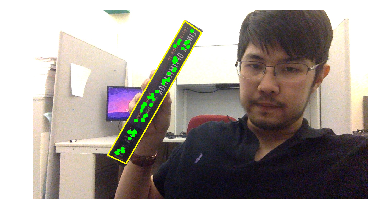

In [236]:
scene_path = 'scene1.jpg'
query_path = 'book3.jpg'

scene = cv2.imread(scene_path, 0) 
scene_color = cv2.imread(scene_path) 
query = cv2.imread(query_path, 0)

# import SIFT keypoint detector
sift = cv2.xfeatures2d.SIFT_create()

# FLANN parameters
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv2.FlannBasedMatcher(index_params,search_params)

# Compute keypoints and descriptors
kp_query, des_query = sift.detectAndCompute(query, None)  
kp_scene, des_scene = sift.detectAndCompute(scene, None)

# Match scene descriptors with query descriptors
matches = flann.knnMatch(des_query,des_scene,k=2)

# ratio test as per Lowe's paper
good_matches = []

# Each member of the matches list must be checked whether two neighbours really exist.
for m_n in matches:
    if len(m_n) != 2:
        continue
    (m,n) = m_n
    if m.distance < 0.7*n.distance:
        good_matches.append(m)

print "{} matches found".format(len(good_matches))

# If enough matches found
if len(good_matches) > 15:

    # Source points nad destnation points
    src_pts = np.float32([kp_query[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp_scene[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    
    for pt in dst_pts:
        (x,y) = pt[0]        
        cv2.circle(scene_color,(int(x),int(y)), 2, (0,255,0), 10)
        
    
    # compute Homography
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)


    print M
    
    # Draw a rectangle that marks the found model in the frame
    h, w = query.shape
    pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
    # project corners into frame
    dst = cv2.perspectiveTransform(pts, M)
    
    # Draw lines
    cv2.polylines(scene_color, [np.int32(dst)], True, (0, 255, 255), 3, cv2.LINE_AA) 

imshow(scene_color)

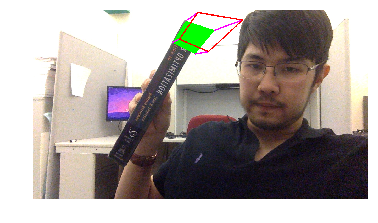

In [237]:
scene_path = 'scene1.jpg'
query_path = 'book1.jpg'

scene = cv2.imread(scene_path, 0) 
scene_color = cv2.imread(scene_path) 
query = cv2.imread(query_path, 0)

mtx = np.array([[ 702.371514,      0.,          282.89455565],
       [   0.,          701.171975,    202.12671729],
       [   0.,            0.,            1.        ]])

dist = np.array([[ 0.20128483, -1.94971807, -0.0144107,  -0.01528961,  7.50933323]])

b = np.zeros((63,1,3))
b[:,:,:-1] = src_pts

# M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
# print M


src_pts = b
src_pts = src_pts.reshape(-1, 3)
dst_pts = dst_pts.reshape(-1, 2)



_, rvecs, tvecs, _ = cv2.solvePnPRansac(src_pts, dst_pts, mtx, dist)

# axis = np.float32([[100,0,0], [0,100,0], [0,0,-100]]).reshape(-1,3)

# Vertices of the square
axis = np.float32([[0,0,0], [0,100,0], [100,100,0], [100,0,0], [0,0,-100], [0,100,-100],[100,100,-100],[100,0,-100]])
imgpts, jac = cv2.projectPoints(axis, rvecs, tvecs, mtx, dist)

#Starting point
vert = np.float32([[0,0,0]]).reshape(-1,3)
v, jac1 = cv2.projectPoints(vert, rvecs, tvecs, mtx, dist)

# print imgpts
img = draw(scene_color,v,imgpts)

# dst = cv2.warpPerspective(scene, M, (1000, 1000));

imshow(img)

In [238]:
print imgpts

[[[ 584.28771973   41.89624405]]

 [[ 532.98156738  124.84967804]]

 [[ 619.31445312  167.11534119]]

 [[ 693.38867188   77.34880829]]

 [[ 629.9052124     9.22570801]]

 [[ 559.71838379  111.08210754]]

 [[ 670.99761963  158.18463135]]

 [[ 800.85809326   38.19669342]]]


In [153]:
def draw(img, corners, imgpts):
    corner = tuple(corners[0].ravel())
    img = cv2.line(img, corner, tuple(imgpts[0].ravel()), (255,0,0), 5) 
    img = cv2.line(img, corner, tuple(imgpts[1].ravel()), (0,255,0), 5) 
    img = cv2.line(img, corner, tuple(imgpts[2].ravel()), (0,0,255), 5) 
    return img

In [179]:
def draw(img, corners, imgpts):
    imgpts = np.int32(imgpts).reshape(-1,2)
    # draw ground floor in green
    img = cv2.drawContours(img, [imgpts[:4]],-1,(0,255,0),-3)
    # draw pillars in blue color
    for i,j in zip(range(4),range(4,8)):
        cv2.line(img, tuple(imgpts[i]), tuple(imgpts[j]),(255, 0, 255),3)
        # draw top layer in red color
        cv2.drawContours(img, [imgpts[4:]],-1,(0,0,255),3)
    return img

#### Decompose Homography Matrix

In [243]:
scene_path = 'scene1.jpg'
query_path = 'book1.jpg'

scene = cv2.imread(scene_path, 0) 
scene_color = cv2.imread(scene_path) 
query = cv2.imread(query_path, 0)

mtx = np.array([[ 702.371514,      0.,          282.89455565],
       [   0.,          701.171975,    202.12671729],
       [   0.,            0.,            1.        ]])

dist = np.array([[ 0.20128483, -1.94971807, -0.0144107,  -0.01528961,  7.50933323]])

_, Rs, Ts, Ns = cv2.decomposeHomographyMat(M, mtx)

rvecs = np.array(Rs[0])
tvecs = np.array(Ts[0])


axis = np.float32([[0,0,0], [0,100,0], [100,100,0], [100,0,0], [0,0,-100], [0,100,-100],[100,100,-100],[100,0,-100]])

imgpts, jac = cv2.projectPoints(axis, rvecs, tvecs, mtx, dist)

vert = np.float32([[0,0,0]]).reshape(-1,3)
v, jac1 = cv2.projectPoints(vert, rvecs, tvecs, mtx, dist)

print imgpts
print v


# # print imgpts
img = draw(scene_color,v,imgpts)

# # dst = cv2.warpPerspective(scene, M, (1000, 1000));

imshow(img)

[[[  1.77034752e+08   6.81733600e+07]]

 [[ -2.98460015e+15   5.07047411e+15]]

 [[  7.35858624e+08   2.96607565e+09]]

 [[  4.09862624e+08   2.42746736e+08]]

 [[  1.62829025e+02   1.17336494e+02]]

 [[  2.88537036e+03  -7.07298730e+03]]

 [[ -2.14851625e+05  -6.42047312e+05]]

 [[ -6.94502188e+04  -4.25153242e+04]]]
[[[  1.77034752e+08   6.81733600e+07]]]


KeyboardInterrupt: 